## Shell APD training <a class="anchor" id="intro"></a>

Intro text

## Navigation

#### Day 1

0. [Introduction](#intro)
1. [Import packages](#setup)
2. [Get the data](#data)
3. [Initial formatting of the data](#init_edit)
    - [Figure out new information](#new_info)
    - [Merge with other tables](#merge)
    - [Aggregate by day](#day_agg)
    - [Aggregate by week](#week_agg)
    
4. [Initial attempt at training](#train_first)
     - [Train](#leakage_train)
     - [Fix leakage](#fix_leakage)
     
5. [Feature engineering](#feature_engineering)

6. [Bring everything together](#bring_together)
     
   
5. [Final training](#model)
    - [Overfitting model](#overfit)
    - [Final model](#final_model)

# 1. Import packages <a class="anchor" id="setup"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
import numpy as np


pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)

# 2. Reading data <a class="anchor" id="data"></a>

In [2]:
df_transactions = pd.read_csv('data/transactions.csv')
df_demographics = pd.read_csv('data/demographics.csv')
df_products = pd.read_csv('data/products.csv')
# old_promotions = pd.read_csv('time_on_app.csv')
df_promotions = pd.read_csv('data/promotions.csv')
df_campaigns = pd.read_csv('data/campaigns.csv')

In [3]:
df_transactions.head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,98,782443249,0.39,1.0,0.00
1,1,1,98,3112548822,3.00,2.0,-0.08
2,1,1,98,6571651611,1.15,4.0,0.00
3,1,1,98,8840487053,1.25,1.0,-0.34
4,1,1,212,782443249,0.65,1.0,0.00


In [4]:
df_promotions.sort_values(['HOUSEHOLD_KEY','WEEK_NO']).head()

,WEEK_NO,HOUSEHOLD_KEY,TIME_IN_APP,NUM_COUPONS
0,1,1,11,0
801,2,1,11,0
1602,3,1,11,0
2403,4,1,11,0
3204,5,1,11,0


In [5]:
households = df_transactions['HOUSEHOLD_KEY'].sort_values().unique()
max_week = df_transactions['WEEK_NO'].max()

big_df = pd.DataFrame()

for key in households:
    df = pd.DataFrame()
    df['WEEK_NO'] = np.arange(1,max_week+1)
    df['HOUSEHOLD_KEY'] = key
    
    big_df = pd.concat([big_df,df])

print(big_df.shape)
big_df.head()

(81702, 2)


,WEEK_NO,HOUSEHOLD_KEY
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


# 3. Initial formatting <a class="anchor" id="init_edit"></a>

### Adding time information: month, weekday, season

In [6]:
spring_summer_products = df_products[df_products['COMMODITY_DESC']=='SPRING/SUMMER SEASONAL']['PRODUCT_ID'].to_list()
fall_winter_products = df_products[df_products['COMMODITY_DESC']=='FALL AND WINTER SEASONAL']['PRODUCT_ID'].to_list()
christmas_products = df_products[df_products['COMMODITY_DESC'].str.contains('CHRISTMAS')]['PRODUCT_ID'].to_list()

spring_summer = df_transactions[df_transactions['PRODUCT_ID'].isin(spring_summer_products)]
fall_winter = df_transactions[df_transactions['PRODUCT_ID'].isin(fall_winter_products)]
christmas = df_transactions[df_transactions['PRODUCT_ID'].isin(christmas_products)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


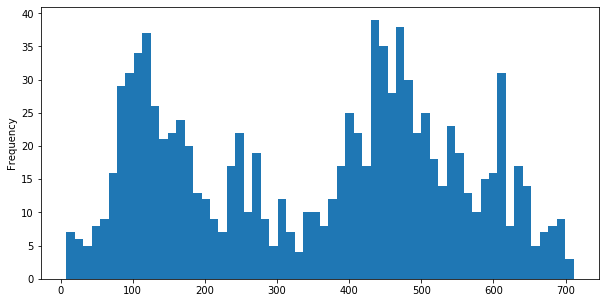

In [7]:
spring_summer['DAY'].plot('hist', bins=60, figsize=(10,5))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


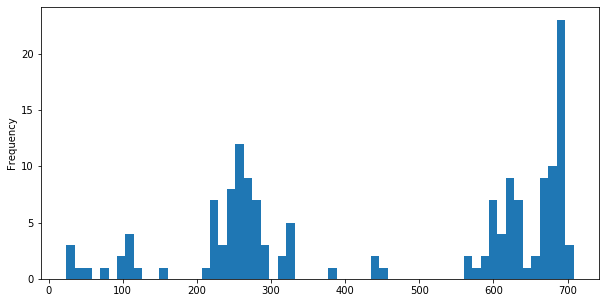

In [8]:
fall_winter['DAY'].plot('hist', bins=60, figsize=(10,5))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


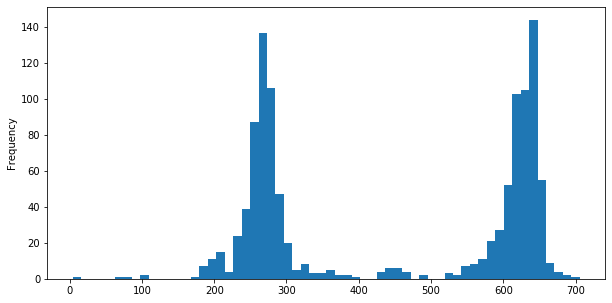

In [9]:
christmas['DAY'].plot('hist', bins=60, figsize=(10,5))

In [10]:
def add_month_names(day):
    day_number = day%340
    if day_number<10:
        return 'February', 2
    elif day_number<40:
        return 'March', 3
    elif day_number<70:
        return 'April', 4
    elif day_number<100:
        return 'May', 5
    elif day_number<130:
        return 'June', 6
    elif day_number<160:
        return 'July', 7
    elif day_number<190:
        return 'August', 8
    elif day_number<220:
        return 'September', 9
    elif day_number<250:
        return 'October', 10
    elif day_number<280:
        return 'November', 11
    elif day_number<310:
        return 'December', 12
    elif day_number<340:
        return 'January', 1

df_transactions['month'], df_transactions['month_num'] = zip(*df_transactions['DAY'].apply(add_month_names))


def add_week_day_names(day):
    day_number = day%7
    if day_number==1:
        return 'Tuesday', day_number+1
    elif day_number==2:
        return 'Wednesday', day_number+1
    elif day_number==3:
        return 'Thursday', day_number+1
    elif day_number==4:
        return 'Friday', day_number+1
    elif day_number==5:
        return 'Saturday', day_number+1
    elif day_number==6:
        return 'Sunday', day_number+1
    elif day_number==0:
        return 'Monday', day_number+1
    
df_transactions['weekday'],df_transactions['weekday_num'] = zip(*df_transactions['DAY'].apply(add_week_day_names))


def get_season(month):
    if month == 'December' or month == 'January' or month == 'February':
        return 'winter'
    elif month == 'March' or month == 'April' or month == 'May':
        return 'spring'
    elif month == 'June' or month == 'July' or month == 'August':
        return 'summer'
    elif month == 'September' or month == 'October' or month == 'November':
        return 'fall'
    
df_transactions['season'] = df_transactions['month'].apply(get_season)



In [11]:
week_month_lookup = df_transactions[['DAY','WEEK_NO','month_num']].drop_duplicates().reset_index().drop('index',axis=1)
week_month_lookup.drop('DAY', axis=1, inplace=True)
week_month_lookup.drop_duplicates(subset=['WEEK_NO'], keep="first", inplace=True)

print(week_month_lookup.shape)
week_month_lookup.head(10)

(102, 2)


,WEEK_NO,month_num
0,1,2
5,2,2
12,3,3
19,4,3
26,5,3
33,6,3
40,7,4
47,8,4
54,9,4
61,10,4


In [12]:
week_month_season_lookup = week_month_lookup.merge(df_transactions[['WEEK_NO','month_num','month','season']].drop_duplicates(), on=['WEEK_NO','month_num'], how='left')
week_month_season_lookup['year'] = week_month_season_lookup['WEEK_NO'].apply(lambda x: 2018 if x>45 and x<=93 else (2017 if x<=45 else 2019))
print(week_month_season_lookup.shape)
week_month_season_lookup.head(200)


(102, 5)


,WEEK_NO,month_num,month,season,year
0,1,2,February,winter,2017
1,2,2,February,winter,2017
2,3,3,March,spring,2017
3,4,3,March,spring,2017
4,5,3,March,spring,2017
5,6,3,March,spring,2017
6,7,4,April,spring,2017
7,8,4,April,spring,2017
8,9,4,April,spring,2017
9,10,4,April,spring,2017


## 2 merge with product table

In [13]:
things_families_buy = df_transactions[['HOUSEHOLD_KEY','PRODUCT_ID']].merge(df_products, on='PRODUCT_ID', how='left')

things_families_buy = things_families_buy[['HOUSEHOLD_KEY','DEPARTMENT','COMMODITY_DESC']]
things_families_buy.sort_values(by='HOUSEHOLD_KEY').head()

things_families_buy.head()



,HOUSEHOLD_KEY,DEPARTMENT,COMMODITY_DESC
0,98,PRODUCE,TROPICAL FRUIT
1,98,GROCERY,COOKIES/CONES
2,98,GROCERY,BAG SNACKS
3,98,GROCERY,BAKED SWEET GOODS
4,212,PRODUCE,TROPICAL FRUIT


In [14]:
most_popular_department = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_department = most_popular_department.groupby('DEPARTMENT').size().reset_index()
most_popular_department.rename(columns={0:'count'}, inplace=True)
most_popular_department = most_popular_department.sort_values('count', ascending=False)
most_popular_department_list = most_popular_department.head()['DEPARTMENT'].tolist()
most_popular_department_list

['GROCERY', 'PRODUCE', 'DRUG GM', 'MEAT-PCKGD', 'MEAT']

In [15]:
most_popular_commodity = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_commodity = most_popular_commodity.groupby('COMMODITY_DESC').size().reset_index()
most_popular_commodity.rename(columns={0:'count'}, inplace=True)
most_popular_commodity = most_popular_commodity.sort_values('count', ascending=False)
most_popular_commodity_list = most_popular_commodity.head()['COMMODITY_DESC'].tolist()
most_popular_commodity_list

['FLUID MILK PRODUCTS',
 'SOFT DRINKS',
 'BAKED BREAD/BUNS/ROLLS',
 'CHEESE',
 'BAG SNACKS']

In [16]:
most_popular_department_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','DEPARTMENT']).size().reset_index()
most_popular_department_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_department_per_family_reduced = most_popular_department_per_family[most_popular_department_per_family['DEPARTMENT'].isin(most_popular_department_list)]

most_popular_department_per_family_reduced.head()


,HOUSEHOLD_KEY,DEPARTMENT,count
1,1,DRUG GM,120
3,1,GROCERY,856
4,1,MEAT,4
5,1,MEAT-PCKGD,91
10,1,PRODUCE,152


In [17]:
popular_department_table = most_popular_department_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'DEPARTMENT', values='count')
popular_department_table.columns.name = None

popular_department_table.fillna(0, inplace=True)
popular_department_table = popular_department_table.reset_index()


print(popular_department_table.shape)
popular_department_table.head()


(801, 6)


,HOUSEHOLD_KEY,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE
0,1,120.0,856.0,4.0,91.0,152.0
1,7,115.0,569.0,35.0,23.0,117.0
2,8,148.0,844.0,52.0,64.0,147.0
3,13,290.0,1059.0,1.0,74.0,109.0
4,16,31.0,303.0,15.0,17.0,42.0


In [18]:
most_popular_commodity_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','COMMODITY_DESC']).size().reset_index()
most_popular_commodity_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_commodity_per_family_reduced = most_popular_commodity_per_family[most_popular_commodity_per_family['COMMODITY_DESC'].isin(most_popular_commodity_list)]

most_popular_commodity_per_family_reduced.head()


,HOUSEHOLD_KEY,COMMODITY_DESC,count
4,1,BAG SNACKS,43
5,1,BAKED BREAD/BUNS/ROLLS,61
21,1,CHEESE,38
55,1,FLUID MILK PRODUCTS,40
113,1,SOFT DRINKS,29


In [19]:
popular_commodity_table = most_popular_commodity_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'COMMODITY_DESC', values='count')
popular_commodity_table.columns.name = None

popular_commodity_table.fillna(0, inplace=True)
popular_commodity_table = popular_commodity_table.reset_index()

print(popular_commodity_table.shape)
popular_commodity_table.head()


(801, 6)


,HOUSEHOLD_KEY,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS
0,1,43.0,61.0,38.0,40.0,29.0
1,7,18.0,27.0,23.0,23.0,12.0
2,8,18.0,44.0,42.0,42.0,29.0
3,13,31.0,35.0,43.0,102.0,33.0
4,16,10.0,68.0,5.0,45.0,5.0


## aggregate by day

In [20]:
daily_transactions = df_transactions.groupby(["HOUSEHOLD_KEY", "DAY",'WEEK_NO'])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
daily_transactions.head()


,HOUSEHOLD_KEY,DAY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,51,8,78.66,34.0,-16.54
1,1,67,10,41.10,14.0,-8.59
2,1,88,13,26.90,13.0,-6.72
3,1,94,14,63.43,32.0,-11.58
4,1,101,15,53.45,20.0,-16.42


In [21]:
daily_transactions['last_shopping_day'] = daily_transactions.groupby('HOUSEHOLD_KEY')['DAY'].shift(1)
daily_transactions['days_since_shopping'] = daily_transactions['DAY']-daily_transactions['last_shopping_day']
daily_transactions = daily_transactions[['HOUSEHOLD_KEY','DAY','WEEK_NO','days_since_shopping']]
daily_transactions.head(400)

,HOUSEHOLD_KEY,DAY,WEEK_NO,days_since_shopping
0,1,51,8,NaN
1,1,67,10,16.0
2,1,88,13,21.0
3,1,94,14,6.0
4,1,101,15,7.0
5,1,108,16,7.0
6,1,111,17,3.0
7,1,128,19,17.0
8,1,137,20,9.0
9,1,146,22,9.0


In [22]:
# WE ARE GOING TO NEED IT IN WEEK FORMAT

# keep last
# previous_visit_day = daily_transactions.drop_duplicates(subset=['HOUSEHOLD_KEY','WEEK_NO'], keep="last")
# previous_visit_day.drop('DAY', axis=1, inplace=True)
# previous_visit_day.head()

# keep average
previous_visit_day = daily_transactions.groupby(['HOUSEHOLD_KEY','WEEK_NO']).mean().reset_index()
previous_visit_day.drop('DAY', axis=1, inplace=True)
previous_visit_day.head()


,HOUSEHOLD_KEY,WEEK_NO,days_since_shopping
0,1,8,NaN
1,1,10,16.0
2,1,13,21.0
3,1,14,6.0
4,1,15,7.0


In [23]:
def fill_nas_for_last_day(days_since_shopping):

    new_column = []
    days_since_column = days_since_shopping.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    next_day_since_value = 0
    
    for i in range(0,len(days_since_column)):
        num_weeks = 1
        value = days_since_column[i]
        
        if math.isnan(value):
            a = i+1
            if a<len(days_since_column):
                next_day_since_value = days_since_column[a]

                #get the next since value
                while math.isnan(next_day_since_value) and a<len(days_since_column)-1:
                    a = a+1
#                     print(a)
                    next_day_since_value = days_since_column[a]
                    num_weeks = num_weeks+1

                if next_day_since_value >= 7*num_weeks:
                    value = next_day_since_value-7*num_weeks

            new_column.append(value)
    #             print('number of weeks: ' + str(num_weeks))
    #             print('instead of nan: ' + str(value))
            
        else:
#             print('*****' + str(value))
            new_column.append(value)
    
    return pd.Series(new_column, index=days_since_shopping.index)


In [24]:
a = big_df.merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
a['days_since_last_shopping'] = a.groupby('HOUSEHOLD_KEY')['days_since_shopping'].apply(fill_nas_for_last_day)

In [25]:
previous_visit_day = a[['HOUSEHOLD_KEY', 'WEEK_NO', 'days_since_last_shopping']].copy()
print(previous_visit_day.shape)
previous_visit_day.head(20)

(81702, 3)


,HOUSEHOLD_KEY,WEEK_NO,days_since_last_shopping
0,1,1,NaN
1,1,2,NaN
2,1,3,NaN
3,1,4,NaN
4,1,5,NaN
5,1,6,NaN
6,1,7,NaN
7,1,8,2.0
8,1,9,9.0
9,1,10,16.0


In [26]:
previous_visit_day.isna().sum()

HOUSEHOLD_KEY                   0
WEEK_NO                         0
days_since_last_shopping    11150
dtype: int64

## aggregate to weekly

In [27]:
transactions_weekly_aggregated = df_transactions.groupby(["HOUSEHOLD_KEY", "WEEK_NO"])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
transactions_weekly_aggregated = transactions_weekly_aggregated.sort_values(by=['HOUSEHOLD_KEY','WEEK_NO']).reset_index().drop('index', axis=1)
transactions_weekly_aggregated.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,8,78.66,34.0,-16.54
1,1,10,41.10,14.0,-8.59
2,1,13,26.90,13.0,-6.72
3,1,14,63.43,32.0,-11.58
4,1,15,53.45,20.0,-16.42


In [28]:
# we'll add this feature a bit later in the notebook
# transactions_weekly_aggregated['prev_amount'] = transactions_weekly_aggregated['SALES_VALUE'].shift(1)

In [29]:
transactions_weekly_aggregated.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,8,78.66,34.0,-16.54
1,1,10,41.10,14.0,-8.59
2,1,13,26.90,13.0,-6.72
3,1,14,63.43,32.0,-11.58
4,1,15,53.45,20.0,-16.42


In [30]:
# # we need to generate the fake variable here and save it before the training

# from random import randint
# import numpy as np


# #time spent on the app's discount section
# data = transactions_weekly_aggregated.copy()

# noise = np.random.normal(0,1,data.shape[0])
# noise

# data['time_spent_on_app'] = (data['SALES_VALUE']/10 - data['prev_amount'] + 3*noise + 400) *0.2
# data['time_spent_on_app'] = data['time_spent_on_app'].apply(lambda x: x+100 if x<0 else x)
# min_val = int(data['time_spent_on_app'].min())
# max_val = int(data['time_spent_on_app'].max())
# data['time_spent_on_app'] = data['time_spent_on_app'].apply(lambda x: x+100 if x<(randint(min_val,max_val)*0.3) else x)
# data['time_spent_on_app'] = data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['time_spent_on_app'].shift(-1)

# df_promotions = data[['HOUSEHOLD_KEY','WEEK_NO','time_spent_on_app']]
# df_promotions.to_csv('time_on_app.csv', index=False)
# df_promotions.head()


## Every week for every household - base table

In [31]:
# TODO: new table with all households and all weeks for aggregated weekly transaction

In [32]:
start_df = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
start_df = start_df.fillna(0)
print(start_df.shape)
start_df.head()

(81702, 5)


,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0


## Preliminary prediction

In [33]:
# Merge everything together

# start_df = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
# start_df = start_df.fillna(0)

a = start_df.merge(df_demographics, on='HOUSEHOLD_KEY', how='left')
b = a.merge(df_campaigns, on='WEEK_NO', how='left')
c = b.merge(df_promotions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
d = c.merge(week_month_season_lookup, on='WEEK_NO', how='left')
e = d.merge(popular_department_table, on='HOUSEHOLD_KEY', how='left')
f = e.merge(popular_commodity_table, on='HOUSEHOLD_KEY', how='left')
g = f.merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
all_data = g.copy()
all_data.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,TIME_IN_APP,NUM_COUPONS,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,days_since_last_shopping
0,1,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-8,11,0,2,February,winter,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
1,2,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-4,11,0,2,February,winter,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
2,3,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-8,11,0,3,March,spring,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
3,4,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-2,11,0,3,March,spring,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
4,5,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-6,11,0,3,March,spring,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN


In [34]:
all_data.columns

Index(['WEEK_NO', 'HOUSEHOLD_KEY', 'SALES_VALUE', 'QUANTITY', 'DISCOUNT',
       'AGE_MEAN', 'HOUSEHOLD_SIZE', 'NUM_ADULTS', 'NUM_CHILDREN',
       'MARITAL_STATUS', 'INCOME_MEAN', 'NUM_CAMPAIGNS', 'FUEL_PRICE_DIFF',
       'TIME_IN_APP', 'NUM_COUPONS', 'month_num', 'month', 'season', 'year',
       'DRUG GM', 'GROCERY', 'MEAT', 'MEAT-PCKGD', 'PRODUCE', 'BAG SNACKS',
       'BAKED BREAD/BUNS/ROLLS', 'CHEESE', 'FLUID MILK PRODUCTS',
       'SOFT DRINKS', 'days_since_last_shopping'],
      dtype='object')

In [35]:
all_columns = ['QUANTITY', 
                 'DISCOUNT',

#                  'prev_amount', 

                 'AGE_MEAN', 
                 'HOUSEHOLD_SIZE', 
                 'NUM_ADULTS',
    #                          'MARITAL_STATUS', 
                 'INCOME_MEAN', 

                 'NUM_CAMPAIGNS', 
                 'FUEL_PRICE_DIFF',
#                  'TIME_IN_APP', 
                 'NUM_COUPONS',

                 'month_num',
                 'month',
                 'season',

                 'DRUG GM', 
                 'GROCERY', 
                 'MEAT',
                 'MEAT-PCKGD', 
                 'PRODUCE', 
                 'BAG SNACKS', 
                 'BAKED BREAD/BUNS/ROLLS',
                 'CHEESE', 
                 'FLUID MILK PRODUCTS',
                 'SOFT DRINKS', 

                 'days_since_last_shopping',
                 'SALES_VALUE']

columns_to_predict_on = [x for x in all_columns if x != 'SALES_VALUE']

# columns_to_predict_on = ['QUANTITY', 'DISCOUNT',
#        'AGE_MEAN', 'HOUSEHOLD_SIZE', 'NUM_ADULTS', 'MARITAL_STATUS',
#        'INCOME_MEAN', 'NUM_CAMPAIGNS', 'FUEL_PRICE_DIFF', 'month_num', 'TIME_IN_APP']

training_data = all_data[all_columns]



In [36]:

training_data.isna().sum()

QUANTITY                        0
DISCOUNT                        0
AGE_MEAN                        0
HOUSEHOLD_SIZE                  0
NUM_ADULTS                      0
INCOME_MEAN                     0
NUM_CAMPAIGNS                   0
FUEL_PRICE_DIFF                 0
NUM_COUPONS                     0
month_num                       0
month                           0
season                          0
DRUG GM                         0
GROCERY                         0
MEAT                            0
MEAT-PCKGD                      0
PRODUCE                         0
BAG SNACKS                      0
BAKED BREAD/BUNS/ROLLS          0
CHEESE                          0
FLUID MILK PRODUCTS             0
SOFT DRINKS                     0
days_since_last_shopping    11150
SALES_VALUE                     0
dtype: int64

In [37]:
training_data.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:

X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

(70552, 37)


In [39]:
# option 1 - temporal split
total_data_amount = X.shape[0]
training_amount = int(total_data_amount*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

In [40]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-rmse:39.6744	train-rmse:36.125
[1]	eval-rmse:27.752	train-rmse:24.3183
[2]	eval-rmse:26.1117	train-rmse:22.183
[3]	eval-rmse:26.1202	train-rmse:21.5378
[4]	eval-rmse:26.0032	train-rmse:21.1024
[5]	eval-rmse:26.0268	train-rmse:20.8698
[6]	eval-rmse:26.3918	train-rmse:20.6359
[7]	eval-rmse:26.4242	train-rmse:20.4663
[8]	eval-rmse:26.4845	train-rmse:20.367
[9]	eval-rmse:26.5247	train-rmse:20.2293
[10]	eval-rmse:26.733	train-rmse:20.099
[11]	eval-rmse:27.6302	train-rmse:19.8379
[12]	eval-rmse:27.6932	train-rmse:19.7953
[13]	eval-rmse:27.754	train-rmse:19.6926
[14]	eval-rmse:27.7631	train-rmse:19.4606


In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))

mean absolute error: 16.47573635209277
mean squared error: 770.8008725617966
root mean squared error: 27.763300822521025
mean absolute percentage error: 27.763300822521025
R2: 0.8693967461526928


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


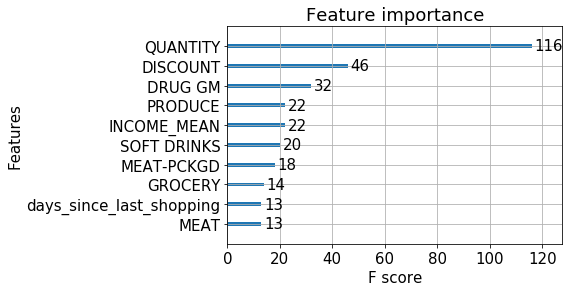

In [42]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)

In [43]:
# fix leakage problem
#1
all_data['QUANTITY'] = all_data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['QUANTITY'].shift(1)

# #2
all_data['DISCOUNT'] = all_data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['DISCOUNT'].shift(1)


all_data['TIME_IN_APP'] =  all_data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['TIME_IN_APP'].shift(1)


# d['NUM_COUPONS'] = d.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['NUM_COUPONS'].shift(1)


In [44]:
training_data = all_data[all_columns]
training_data.isna().sum()

QUANTITY                      801
DISCOUNT                      801
AGE_MEAN                        0
HOUSEHOLD_SIZE                  0
NUM_ADULTS                      0
INCOME_MEAN                     0
NUM_CAMPAIGNS                   0
FUEL_PRICE_DIFF                 0
NUM_COUPONS                     0
month_num                       0
month                           0
season                          0
DRUG GM                         0
GROCERY                         0
MEAT                            0
MEAT-PCKGD                      0
PRODUCE                         0
BAG SNACKS                      0
BAKED BREAD/BUNS/ROLLS          0
CHEESE                          0
FLUID MILK PRODUCTS             0
SOFT DRINKS                     0
days_since_last_shopping    11150
SALES_VALUE                     0
dtype: int64

In [45]:
training_data.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

(70537, 37)


In [47]:

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-rmse:70.3559	train-rmse:62.0742
[1]	eval-rmse:65.8248	train-rmse:57.178
[2]	eval-rmse:64.4125	train-rmse:55.5052
[3]	eval-rmse:64.2471	train-rmse:54.986
[4]	eval-rmse:64.1124	train-rmse:54.4914
[5]	eval-rmse:63.7703	train-rmse:53.9949
[6]	eval-rmse:64.2467	train-rmse:53.4793
[7]	eval-rmse:64.2277	train-rmse:53.2868
[8]	eval-rmse:64.1944	train-rmse:53.1111
[9]	eval-rmse:64.2592	train-rmse:52.9219
[10]	eval-rmse:64.2998	train-rmse:52.6448
[11]	eval-rmse:64.4624	train-rmse:52.5594
[12]	eval-rmse:64.451	train-rmse:52.2589
[13]	eval-rmse:64.4728	train-rmse:52.151
[14]	eval-rmse:64.3599	train-rmse:51.9947


In [48]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))

mean absolute error: 44.98310098483503
mean squared error: 4142.2007539421475
root mean squared error: 64.35993127670467
mean absolute percentage error: 64.35993127670467
R2: 0.29811314295052216


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


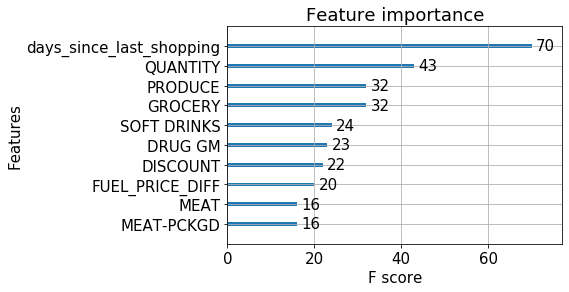

In [49]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)

# Feature Engineering <a class="anchor" id="feature_engineering"></a>

In [50]:
all_data.shape

(81702, 30)

In [51]:
transactions_weekly_aggregated.head(30)

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,8,78.66,34.0,-16.54
1,1,10,41.10,14.0,-8.59
2,1,13,26.90,13.0,-6.72
3,1,14,63.43,32.0,-11.58
4,1,15,53.45,20.0,-16.42
5,1,16,26.76,11.0,-7.24
6,1,17,23.55,12.0,-3.97
7,1,19,110.34,43.0,-10.44
8,1,20,87.44,43.0,-18.13
9,1,22,73.32,32.0,-13.67


### 1. Amount spent on last shopping trip

In [52]:
spent_last_trip_df = transactions_weekly_aggregated.copy()
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df['SALES_VALUE']#.shift(1)

spent_last_trip_df = big_df.merge(spent_last_trip_df[['HOUSEHOLD_KEY','WEEK_NO','amount_spent_last_trip']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
spent_last_trip_df.head()

,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_trip
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN


In [53]:
def fill_nas_for_spent_trip(amount_spent_last_trip):

    new_column = []
    amount_spent_last_trip_column = amount_spent_last_trip.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(amount_spent_last_trip_column)):
        amount = amount_spent_last_trip_column[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=amount_spent_last_trip.index)


In [54]:
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df.groupby('HOUSEHOLD_KEY')['amount_spent_last_trip'].apply(fill_nas_for_spent_trip)
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df['amount_spent_last_trip'].shift(1)
spent_last_trip_df.head()


,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_trip
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN


### 2. Amount spent last week

In [55]:
spent_last_week_df = transactions_weekly_aggregated.copy()
spent_last_week_df = big_df.merge(spent_last_week_df[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
spent_last_week_df['amount_spent_last_week'] = spent_last_week_df['SALES_VALUE'].shift(1)
spent_last_week_df['amount_spent_last_week'].fillna(0, inplace=True)
spent_last_week_df = spent_last_week_df[['WEEK_NO','HOUSEHOLD_KEY','amount_spent_last_week']]
spent_last_week_df.head(40)

,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_week
0,1,1,0.00
1,2,1,0.00
2,3,1,0.00
3,4,1,0.00
4,5,1,0.00
5,6,1,0.00
6,7,1,0.00
7,8,1,0.00
8,9,1,78.66
9,10,1,0.00


### 3. Number of weeks since last shopping

In [56]:
num_weeks_since_last_visit = transactions_weekly_aggregated.copy()
num_weeks_since_last_visit['last_shopping_week'] = num_weeks_since_last_visit.groupby('HOUSEHOLD_KEY')['WEEK_NO'].shift(1)
num_weeks_since_last_visit['weeks_since_last_shopping'] = num_weeks_since_last_visit['WEEK_NO']-num_weeks_since_last_visit['last_shopping_week']

num_weeks_since_last_visit = num_weeks_since_last_visit[['HOUSEHOLD_KEY','WEEK_NO','weeks_since_last_shopping']]



In [57]:
num_weeks_since_last_visit = big_df.merge(num_weeks_since_last_visit, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
print(num_weeks_since_last_visit.shape)
num_weeks_since_last_visit.head()

(81702, 3)


,WEEK_NO,HOUSEHOLD_KEY,weeks_since_last_shopping
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN


In [58]:
def fill_nas_for_last_week(weeks_since_shopping):

    new_column = []
    weeks_since_column = weeks_since_shopping.tolist()
#     print(weeks_since_column)
#     print(len(weeks_since_column))
    
    next_day_since_value = 0
    
    for i in range(0,len(weeks_since_column)):
        num_weeks = 1
        value = weeks_since_column[i]
        
        if math.isnan(value):
            a = i+1
            if a<len(weeks_since_column):
                next_day_since_value = weeks_since_column[a]

                #get the next since value
                while math.isnan(next_day_since_value) and a<len(weeks_since_column)-1:
                    a = a+1
#                     print(a)
                    next_day_since_value = weeks_since_column[a]
                    num_weeks = num_weeks+1

                if next_day_since_value >= num_weeks:
                    value = next_day_since_value-num_weeks

            new_column.append(value)
    #             print('number of weeks: ' + str(num_weeks))
    #             print('instead of nan: ' + str(value))
            
        else:
#             print('*****' + str(value))
            new_column.append(value)
    
    return pd.Series(new_column, index=weeks_since_shopping.index)


In [59]:

num_weeks_since_last_visit['weeks_since_last_shopping'] = num_weeks_since_last_visit.groupby('HOUSEHOLD_KEY')['weeks_since_last_shopping'].apply(fill_nas_for_last_week)



In [60]:
num_weeks_since_last_visit.head(10)

,WEEK_NO,HOUSEHOLD_KEY,weeks_since_last_shopping
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,0.0
8,9,1,1.0
9,10,1,2.0


### 4. average spent on previous shopping trips (with stats)

In [61]:
transactions_with_time = transactions_weekly_aggregated.copy()
print(transactions_with_time.shape)
transactions_with_time.head()



(56488, 5)


,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,8,78.66,34.0,-16.54
1,1,10,41.10,14.0,-8.59
2,1,13,26.90,13.0,-6.72
3,1,14,63.43,32.0,-11.58
4,1,15,53.45,20.0,-16.42


In [62]:
mean = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
mean = mean.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().mean()
mean = mean.drop('HOUSEHOLD_KEY', axis=1).reset_index()
mean.index = mean['level_1']

mean = mean.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
mean = mean.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
mean['avg_spending_previous_trips'] = mean.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
mean = mean.drop('SALES_VALUE', axis=1)
# print(mean.shape)
# mean.head(100)

std = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
std = std.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().std()
std = std.drop('HOUSEHOLD_KEY', axis=1).reset_index()
std.index = std['level_1']

std = std.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
std = std.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
std['std_spending_previous_trips'] = std.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
std = std.drop('SALES_VALUE', axis=1)
# print(std.shape)
# std.head(100)

var = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
var = var.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().var()
var = var.drop('HOUSEHOLD_KEY', axis=1).reset_index()
var.index = var['level_1']

var = var.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
var = var.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
var['var_spending_previous_trips'] = var.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
var = var.drop('SALES_VALUE', axis=1)
# print(var.shape)
# var.head(100)

quan25 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan25 = quan25.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.25)
quan25 = quan25.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan25.index = quan25['level_1']

quan25 = quan25.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan25 = quan25.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan25['quan25_spending_previous_trips'] = quan25.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan25 = quan25.drop('SALES_VALUE', axis=1)
# print(quan25.shape)
# quan25.head(100)

quan50 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan50 = quan50.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.5)
quan50 = quan50.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan50.index = quan50['level_1']

quan50 = quan50.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan50 = quan50.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan50['quan50_spending_previous_trips'] = quan50.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan50 = quan50.drop('SALES_VALUE', axis=1)
# print(quan50.shape)
# quan50.head(100)

quan75 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan75 = quan75.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.75)
quan75 = quan75.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan75.index = quan75['level_1']

quan75 = quan75.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan75 = quan75.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan75['quan75_spending_previous_trips'] = quan75.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan75 = quan75.drop('SALES_VALUE', axis=1)
# print(quan75.shape)
# quan75.head(100)

stats_prev_trips = big_df.merge(mean, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(std, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(var, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan25, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan50, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan75, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

print(stats_prev_trips.shape)
stats_prev_trips.head(10)


(81702, 8)


,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN
5,6,1,NaN,NaN,NaN,NaN,NaN,NaN
6,7,1,NaN,NaN,NaN,NaN,NaN,NaN
7,8,1,NaN,NaN,NaN,NaN,NaN,NaN
8,9,1,NaN,NaN,NaN,NaN,NaN,NaN
9,10,1,78.66,NaN,NaN,78.66,78.66,78.66


In [63]:
def fill_nas_for_prev_trip(stats_column):

    new_column = []
    stats_column_list = stats_column.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(stats_column_list)):
        amount = stats_column_list[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=stats_column.index)


In [64]:
for column in stats_prev_trips:
    if column != 'WEEK_NO' or column != 'HOUSEHOLD_KEY':
        stats_prev_trips[column] = stats_prev_trips.groupby('HOUSEHOLD_KEY')[column].apply(fill_nas_for_prev_trip)


In [65]:
stats_prev_trips.head()

,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
stats_prev_trips.isna().sum()

WEEK_NO                               0
HOUSEHOLD_KEY                         0
avg_spending_previous_trips        9114
std_spending_previous_trips       10660
var_spending_previous_trips       10660
quan25_spending_previous_trips     9114
quan50_spending_previous_trips     9114
quan75_spending_previous_trips     9114
dtype: int64

## 5. average spent on previous weeks (with stats)

In [67]:
transactions_every_week = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
transactions_every_week.fillna(0, inplace=True)
transactions_every_week.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0


In [68]:
mean_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
mean_r = mean_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().mean()
mean_r = mean_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
mean_r.index = mean_r['level_1']

mean_r = mean_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
mean_r = mean_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
mean_r['avg_spending_previous_weeks_real_time'] = mean_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
mean_r = mean_r.drop('SALES_VALUE', axis=1)
# print(mean_r.shape)
# mean_r.head(10)


std_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
std_r = std_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().std()
std_r = std_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
std_r.index = std_r['level_1']

std_r = std_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
std_r = std_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
std_r['std_spending_previous_weeks_real_time'] = std_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
std_r = std_r.drop('SALES_VALUE', axis=1)
# print(std_r.shape)
# std_r.head()


var_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
var_r = var_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().var()
var_r = var_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
var_r.index = var_r['level_1']

var_r = var_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
var_r = var_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
var_r['var_spending_previous_weeks_real_time'] = var_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
var_r = var_r.drop('SALES_VALUE', axis=1)
# print(var_r.shape)
# var_r.head(10)


quan25_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan25_r = quan25_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.25)
quan25_r = quan25_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan25_r.index = quan25_r['level_1']

quan25_r = quan25_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan25_r = quan25_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan25_r['quan25_spending_previous_weeks_real_time'] = quan25_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan25_r = quan25_r.drop('SALES_VALUE', axis=1)
# print(quan25_r.shape)
# quan25_r.head(10)


quan50_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan50_r = quan50_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.5)
quan50_r = quan50_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan50_r.index = quan50_r['level_1']

quan50_r = quan50_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan50_r = quan50_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan50_r['quan50_spending_previous_weeks_real_time'] = quan50_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan50_r = quan50_r.drop('SALES_VALUE', axis=1)
# print(quan50_r.shape)
# quan50_r.head(10)


quan75_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan75_r = quan75_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.75)
quan75_r = quan75_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan75_r.index = quan75_r['level_1']

quan75_r = quan75_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan75_r = quan75_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan75_r['quan75_spending_previous_weeks_real_time'] = quan75_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan75_r = quan75_r.drop('SALES_VALUE', axis=1)
# print(quan75_r.shape)
# quan75_r.head(10)




In [69]:
stats_prev_weeks = big_df.merge(mean_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(std_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(var_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan25_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan50_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan75_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

print(stats_prev_weeks.shape)
stats_prev_weeks.head(10)

(81702, 8)


,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,0.0000,NaN,NaN,0.0,0.0,0.0
2,3,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
3,4,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
4,5,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
5,6,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
6,7,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
7,8,1,0.0000,0.00000,0.00000,0.0,0.0,0.0
8,9,1,9.8325,27.81051,773.42445,0.0,0.0,0.0
9,10,1,8.7400,26.22000,687.48840,0.0,0.0,0.0


In [70]:
stats_prev_weeks.isna().sum()

WEEK_NO                                        0
HOUSEHOLD_KEY                                  0
avg_spending_previous_weeks_real_time        801
std_spending_previous_weeks_real_time       1602
var_spending_previous_weeks_real_time       1602
quan25_spending_previous_weeks_real_time     801
quan50_spending_previous_weeks_real_time     801
quan75_spending_previous_weeks_real_time     801
dtype: int64

## 6. weighted mean of last 10 trips' spendings

In [71]:
weighted_avg_trips = transactions_weekly_aggregated.copy()
weighted_avg_trips['1_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
weighted_avg_trips['2_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(2)
weighted_avg_trips['3_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(3)
weighted_avg_trips['4_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(4)
weighted_avg_trips['5_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(5)
weighted_avg_trips['6_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(6)
weighted_avg_trips['7_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(7)
weighted_avg_trips['8_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(8)
weighted_avg_trips['9_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(9)
weighted_avg_trips['10_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(10)
weighted_avg_trips.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT,1_times_before,2_times_before,3_times_before,4_times_before,5_times_before,6_times_before,7_times_before,8_times_before,9_times_before,10_times_before
0,1,8,78.66,34.0,-16.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,10,41.10,14.0,-8.59,78.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,13,26.90,13.0,-6.72,41.10,78.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,14,63.43,32.0,-11.58,26.90,41.10,78.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,15,53.45,20.0,-16.42,63.43,26.90,41.10,78.66,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
weighted_avg_trips['weighted_avg'] = (weighted_avg_trips['1_times_before']*10 + 
                               weighted_avg_trips['2_times_before']*9 +
                               weighted_avg_trips['3_times_before']*8 +
                               weighted_avg_trips['4_times_before']*7 +
                               weighted_avg_trips['5_times_before']*6 +
                               weighted_avg_trips['6_times_before']*5 +
                               weighted_avg_trips['7_times_before']*4 +
                               weighted_avg_trips['8_times_before']*3 +
                               weighted_avg_trips['9_times_before']*2 +
                               weighted_avg_trips['10_times_before']*1)/(1+2+3+4+5+6+7+8+9+10)

weighted_avg_trips = weighted_avg_trips[['HOUSEHOLD_KEY','WEEK_NO','weighted_avg']]
weighted_avg_trips.head()

,HOUSEHOLD_KEY,WEEK_NO,weighted_avg
0,1,8,NaN
1,1,10,NaN
2,1,13,NaN
3,1,14,NaN
4,1,15,NaN


In [73]:
weighted_avg_trips = big_df.merge(weighted_avg_trips[['HOUSEHOLD_KEY','WEEK_NO','weighted_avg']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
weighted_avg_trips.head(30)


,WEEK_NO,HOUSEHOLD_KEY,weighted_avg
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,NaN
8,9,1,NaN
9,10,1,NaN


In [74]:
def fill_nas_for_weighted_avg(weighted_avg):

    new_column = []
    weighted_avg_column = weighted_avg.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(weighted_avg_column)):
        amount = weighted_avg_column[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=weighted_avg.index)


In [75]:
weighted_avg_trips['weighted_avg'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['weighted_avg'].apply(fill_nas_for_weighted_avg)
weighted_avg_trips.head(40)


,WEEK_NO,HOUSEHOLD_KEY,weighted_avg
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,NaN
8,9,1,NaN
9,10,1,NaN


## 7. weighted mean of last 10 weeks' spendings

In [76]:
transactions_every_week = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
transactions_every_week.fillna(0, inplace=True)
transactions_every_week.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0


In [77]:
weighted_avg_weeks = transactions_every_week.copy()
weighted_avg_weeks['1_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
weighted_avg_weeks['2_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(2)
weighted_avg_weeks['3_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(3)
weighted_avg_weeks['4_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(4)
weighted_avg_weeks['5_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(5)
weighted_avg_weeks['6_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(6)
weighted_avg_weeks['7_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(7)
weighted_avg_weeks['8_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(8)
weighted_avg_weeks['9_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(9)
weighted_avg_weeks['10_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(10)
weighted_avg_weeks.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,1_times_before,2_times_before,3_times_before,4_times_before,5_times_before,6_times_before,7_times_before,8_times_before,9_times_before,10_times_before
0,1,1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
weighted_avg_weeks['weighted_avg'] = (weighted_avg_weeks['1_times_before']*10 + 
                               weighted_avg_weeks['2_times_before']*9 +
                               weighted_avg_weeks['3_times_before']*8 +
                               weighted_avg_weeks['4_times_before']*7 +
                               weighted_avg_weeks['5_times_before']*6 +
                               weighted_avg_weeks['6_times_before']*5 +
                               weighted_avg_weeks['7_times_before']*4 +
                               weighted_avg_weeks['8_times_before']*3 +
                               weighted_avg_weeks['9_times_before']*2 +
                               weighted_avg_weeks['9_times_before']*1)/(1+2+3+4+5+6+7+8+9+10)

weighted_avg_weeks = weighted_avg_weeks[['HOUSEHOLD_KEY','WEEK_NO','weighted_avg']]
weighted_avg_weeks.head(20)

,HOUSEHOLD_KEY,WEEK_NO,weighted_avg
0,1,1,NaN
1,1,2,NaN
2,1,3,NaN
3,1,4,NaN
4,1,5,NaN
5,1,6,NaN
6,1,7,NaN
7,1,8,NaN
8,1,9,NaN
9,1,10,12.871636


## 7. average visits per week

In [79]:
family_weekly_visits = df_transactions[['HOUSEHOLD_KEY','DAY','WEEK_NO']].drop_duplicates()
family_weekly_visits = family_weekly_visits.groupby(['HOUSEHOLD_KEY','WEEK_NO']).size().reset_index()
family_weekly_visits.rename(columns={0:'week_visit_count'}, inplace=True)
week_visit_count = family_weekly_visits.copy()

print(week_visit_count.shape)
week_visit_count.head()

(56488, 3)


,HOUSEHOLD_KEY,WEEK_NO,week_visit_count
0,1,8,1
1,1,10,1
2,1,13,1
3,1,14,1
4,1,15,1


In [80]:
expanded_weekly_visit_count = big_df.merge(week_visit_count, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').fillna(0)

print(expanded_weekly_visit_count.shape)
expanded_weekly_visit_count.head()

(81702, 3)


,WEEK_NO,HOUSEHOLD_KEY,week_visit_count
0,1,1,0.0
1,2,1,0.0
2,3,1,0.0
3,4,1,0.0
4,5,1,0.0


In [81]:
rolling_avg_weekly_visit = expanded_weekly_visit_count.sort_values('WEEK_NO').copy()

rolling_avg_weekly_visit = pd.DataFrame(rolling_avg_weekly_visit.groupby('HOUSEHOLD_KEY')['week_visit_count'].expanding().mean())
rolling_avg_weekly_visit = rolling_avg_weekly_visit.reset_index()
rolling_avg_weekly_visit.drop('level_1', axis=1, inplace=True)

week_col = [[i for i in range(1,103)]]*801
week_col = [i for sublist in week_col for i in sublist]
print(len(week_col))

rolling_avg_weekly_visit['WEEK_NO'] = week_col

print(rolling_avg_weekly_visit.shape)
rolling_avg_weekly_visit.head()

81702
(81702, 3)


,HOUSEHOLD_KEY,week_visit_count,WEEK_NO
0,1,0.0,1
1,1,0.0,2
2,1,0.0,3
3,1,0.0,4
4,1,0.0,5


In [82]:
average_from_past_weeks = rolling_avg_weekly_visit.copy()

average_from_past_weeks['avg_visits_per_week'] = average_from_past_weeks.groupby('HOUSEHOLD_KEY')['week_visit_count'].shift(1)
average_from_past_weeks.drop('week_visit_count', axis=1, inplace=True)

print(average_from_past_weeks.shape)
average_from_past_weeks.head()



(81702, 3)


,HOUSEHOLD_KEY,WEEK_NO,avg_visits_per_week
0,1,1,NaN
1,1,2,0.0
2,1,3,0.0
3,1,4,0.0
4,1,5,0.0


## 8. average visits per month

In [83]:
weekly_visit_count = rolling_avg_weekly_visit.copy()
weekly_visit_count['year'] = weekly_visit_count['WEEK_NO'].apply(lambda x: 2018 if x>45 and x<=93 else (2017 if x<=45 else 2019))

weekly_visit_count = weekly_visit_count.merge(week_month_lookup, on=['WEEK_NO'], how='left')

print(weekly_visit_count.shape)
weekly_visit_count.head()

(81702, 5)


,HOUSEHOLD_KEY,week_visit_count,WEEK_NO,year,month_num
0,1,0.0,1,2017,2
1,1,0.0,2,2017,2
2,1,0.0,3,2017,3
3,1,0.0,4,2017,3
4,1,0.0,5,2017,3


In [84]:
monthly_visit_count = weekly_visit_count.drop('WEEK_NO', axis=1)
monthly_visit_count = pd.DataFrame(monthly_visit_count.groupby(['HOUSEHOLD_KEY','month_num','year'])['week_visit_count'].sum())
monthly_visit_count = monthly_visit_count.reset_index()

monthly_visit_count.rename(columns={'week_visit_count':'month_visit_count'}, inplace=True)


monthly_visit_count = monthly_visit_count.sort_values(['HOUSEHOLD_KEY','year','month_num'], ascending=True).reset_index().drop('index', axis=1)


print(monthly_visit_count.shape)
monthly_visit_count.head()


(20826, 4)


,HOUSEHOLD_KEY,month_num,year,month_visit_count
0,1,2,2017,0.000000
1,1,3,2017,0.000000
2,1,4,2017,0.617929
3,1,5,2017,1.016484
4,1,6,2017,1.596706


In [85]:
month_year_table = monthly_visit_count[['year','month_num']]

month_year_table.head(100)

,year,month_num
0,2017,2
1,2017,3
2,2017,4
3,2017,5
4,2017,6
5,2017,7
6,2017,8
7,2017,9
8,2017,10
9,2017,11


In [86]:
rolling_avg_monthly_visits = monthly_visit_count.copy()
rolling_avg_monthly_visits = pd.DataFrame(rolling_avg_monthly_visits.groupby('HOUSEHOLD_KEY')['month_visit_count'].expanding().mean())
rolling_avg_monthly_visits = rolling_avg_monthly_visits.reset_index()
rolling_avg_monthly_visits.drop('level_1', axis=1, inplace=True)

rolling_avg_monthly_visits = rolling_avg_monthly_visits.join(month_year_table)

print(rolling_avg_monthly_visits.shape)
rolling_avg_monthly_visits.head()


(20826, 4)


,HOUSEHOLD_KEY,month_visit_count,year,month_num
0,1,0.000000,2017,2
1,1,0.000000,2017,3
2,1,0.205976,2017,4
3,1,0.408603,2017,5
4,1,0.646224,2017,6


In [87]:
average_from_past_months = rolling_avg_monthly_visits.copy()

average_from_past_months['avg_visits_per_month'] = average_from_past_months.groupby('HOUSEHOLD_KEY')['month_visit_count'].shift(1)
average_from_past_months.drop('month_visit_count', axis=1, inplace=True)

print(average_from_past_months.shape)
average_from_past_months.head()



(20826, 4)


,HOUSEHOLD_KEY,year,month_num,avg_visits_per_month
0,1,2017,2,NaN
1,1,2017,3,0.000000
2,1,2017,4,0.000000
3,1,2017,5,0.205976
4,1,2017,6,0.408603


## 9. proportion of shopping weekdays and time of day

In [88]:
all_hhs = df_transactions['HOUSEHOLD_KEY'].sort_values().drop_duplicates().tolist()
household_column = [[hh]*7*102 for hh in all_hhs]
household_column = [h for sub in household_column for h in sub]

week_col = [[[i]*7 for i in range(1,103)]]*801
week_col = [i for sublist in week_col for i in sublist]
week_col = [i for sublist in week_col for i in sublist]

weekday_column = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']*102*801

all_weeks_households_weekdays = pd.DataFrame(list(zip(household_column,week_col,weekday_column)), columns=['HOUSEHOLD_KEY','WEEK_NO','weekday'])
all_weeks_households_weekdays.head()



,HOUSEHOLD_KEY,WEEK_NO,weekday
0,1,1,Monday
1,1,1,Tuesday
2,1,1,Wednesday
3,1,1,Thursday
4,1,1,Friday


In [89]:
shopping_days = df_transactions[['HOUSEHOLD_KEY','WEEK_NO','weekday']].drop_duplicates()

shopping_days = shopping_days.sort_values(['HOUSEHOLD_KEY','WEEK_NO'])
shopping_days['exists'] = 1

print(shopping_days.shape)
shopping_days.head()

(113305, 4)


,HOUSEHOLD_KEY,WEEK_NO,weekday,exists
14686,1,8,Wednesday,1
23829,1,10,Friday,1
41957,1,13,Friday,1
47880,1,14,Thursday,1
55589,1,15,Thursday,1


In [90]:
all_weeks_households_weekdays_count = all_weeks_households_weekdays.merge(shopping_days, on=['HOUSEHOLD_KEY','WEEK_NO','weekday'], how='left')
all_weeks_households_weekdays_count.fillna(0, inplace=True)

print(all_weeks_households_weekdays_count.shape)
all_weeks_households_weekdays_count.head()


(571914, 4)


,HOUSEHOLD_KEY,WEEK_NO,weekday,exists
0,1,1,Monday,0.0
1,1,1,Tuesday,0.0
2,1,1,Wednesday,0.0
3,1,1,Thursday,0.0
4,1,1,Friday,0.0


In [91]:
grouped_shopping_day_proportions = all_weeks_households_weekdays_count.groupby('HOUSEHOLD_KEY')

new_df = pd.DataFrame()
for name, group in grouped_shopping_day_proportions:
#     print(group)
    hh_key = group['HOUSEHOLD_KEY'].iloc[0]
    
    weekdays = group[['WEEK_NO','weekday','exists']]
    
    week_col = [[i for i in range(1,103)]]*7
    week_col = [i for sublist in week_col for i in sublist]
    
    hh_col = [[hh_key]*102*7]
    hh_col = [h for sub in hh_col for h in sub]
    
    weekdays = weekdays.groupby('weekday').expanding().sum().reset_index()
    
    weekdays['WEEK_NO'] = week_col
    weekdays['HOUSEHOLD_KEY'] = hh_col
    weekdays.drop('level_1', axis=1, inplace=True)
    
    new_df = new_df.append(weekdays)   
    
    
shopping_day_proportions = new_df.copy()

print(shopping_day_proportions.shape)
shopping_day_proportions.head()


(571914, 4)


,weekday,WEEK_NO,exists,HOUSEHOLD_KEY
0,Friday,1,0.0,1
1,Friday,2,0.0,1
2,Friday,3,0.0,1
3,Friday,4,0.0,1
4,Friday,5,0.0,1


In [92]:

shopping_day_proportions.sort_values(['HOUSEHOLD_KEY','WEEK_NO','weekday']).reset_index().drop('index',axis=1).head(300)



,weekday,WEEK_NO,exists,HOUSEHOLD_KEY
0,Friday,1,0.0,1
1,Monday,1,0.0,1
2,Saturday,1,0.0,1
3,Sunday,1,0.0,1
4,Thursday,1,0.0,1
5,Tuesday,1,0.0,1
6,Wednesday,1,0.0,1
7,Friday,2,0.0,1
8,Monday,2,0.0,1
9,Saturday,2,0.0,1


In [93]:
visit_day_counts = pd.pivot_table(shopping_day_proportions, columns = 'weekday', values='exists', index=['HOUSEHOLD_KEY','WEEK_NO'] )

visit_day_counts.head(20)


weekday                Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
HOUSEHOLD_KEY WEEK_NO                                                        
1             1           0.0     0.0       0.0     0.0       0.0      0.0   
              2           0.0     0.0       0.0     0.0       0.0      0.0   
              3           0.0     0.0       0.0     0.0       0.0      0.0   
              4           0.0     0.0       0.0     0.0       0.0      0.0   
              5           0.0     0.0       0.0     0.0       0.0      0.0   
              6           0.0     0.0       0.0     0.0       0.0      0.0   
              7           0.0     0.0       0.0     0.0       0.0      0.0   
              8           0.0     0.0       0.0     0.0       0.0      0.0   
              9           0.0     0.0       0.0     0.0       0.0      0.0   
              10          1.0     0.0       0.0     0.0       0.0      0.0   
              11          1.0     0.0       0.0     0.0       0.0      0.0   
              12          1.0     0.0       0.0     0.0       0.0      0.0   
              13          2.0     0.0       0.0     0.0       0.0      0.0   
              14          2.0     0.0       0.0     0.0       1.0      0.0   
              15          2.0     0.0       0.0     0.0       2.0      0.0   
              16          2.0     0.0       0.0     0.0       3.0      0.0   
              17          2.0     0.0       0.0     1.0       3.0      0.0   
              18          2.0     0.0       0.0     1.0       3.0      0.0   
              19          2.0     0.0       0.0     1.0       3.0      0.0   
              20          3.0     0.0       0.0     1.0       3.0      0.0   

weekday                Wednesday  
HOUSEHOLD_KEY WEEK_NO             
1             1              0.0  
              2              0.0  
              3              0.0  
              4              0.0  
              5              0.0  
              6              0.0  
              7              0.0  
              8              1.0  
              9              1.0  
              10             1.0  
              11             1.0  
              12             1.0  
              13             1.0  
              14             1.0  
              15             1.0  
              16             1.0  
              17             1.0  
              18             1.0  
              19             2.0  
              20             2.0

In [94]:
visit_day_proportions = visit_day_counts.copy()
visit_day_proportions['total_visits'] =  visit_day_proportions[['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].sum(axis=1)

visit_day_proportions = visit_day_proportions[['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].div(visit_day_proportions['total_visits'], axis=0)
    
visit_day_proportions.columns = [str(col) + ' %' for col in visit_day_proportions.columns]
visit_day_proportions = visit_day_proportions.reset_index()
visit_day_proportions.fillna(0, inplace=True)

print(visit_day_proportions.shape)
visit_day_proportions.head(40)

    

(81702, 9)


,HOUSEHOLD_KEY,WEEK_NO,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,1,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,1,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,1,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,1,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
6,1,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7,1,8,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
8,1,9,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
9,1,10,0.000000,0.000000,0.500000,0.000000,0.500000,0.0,0.000000


# Bring everything together <a class="anchor" id="bring_together"></a>

In [95]:
all_data.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,TIME_IN_APP,NUM_COUPONS,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,days_since_last_shopping
0,1,1,0.0,NaN,NaN,65,2,2,0,1.0,42000,0,-8,NaN,0,2,February,winter,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
1,2,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-4,11.0,0,2,February,winter,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
2,3,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-8,11.0,0,3,March,spring,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
3,4,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-2,11.0,0,3,March,spring,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
4,5,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-6,11.0,0,3,March,spring,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN


In [96]:
a = all_data.merge(spent_last_trip_df, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
b = a.merge(spent_last_week_df, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
c = b.merge(num_weeks_since_last_visit, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
d = c.merge(stats_prev_trips, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
e = d.merge(stats_prev_weeks, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
f = e.merge(weighted_avg_trips, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
g = f.merge(weighted_avg_weeks, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
h = g.merge(average_from_past_weeks, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
j = h.merge(average_from_past_months, on=['HOUSEHOLD_KEY','month_num','year'], how='left')
z = j.merge(visit_day_proportions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

print(z.shape)
z.head()

(81702, 56)


,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,TIME_IN_APP,NUM_COUPONS,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,days_since_last_shopping,amount_spent_last_trip,amount_spent_last_week,weeks_since_last_shopping,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time,weighted_avg_x,weighted_avg_y,avg_visits_per_week,avg_visits_per_month,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.0,NaN,NaN,65,2,2,0,1.0,42000,0,-8,NaN,0,2,February,winter,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-4,11.0,0,2,February,winter,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-8,11.0,0,3,March,spring,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-2,11.0,0,3,March,spring,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0,65,2,2,0,1.0,42000,0,-6,11.0,0,3,March,spring,2017,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
z = z[z['SALES_VALUE']<400]

In [98]:
z.isna().sum()

WEEK_NO                                         0
HOUSEHOLD_KEY                                   0
SALES_VALUE                                     0
QUANTITY                                      801
DISCOUNT                                      801
AGE_MEAN                                        0
HOUSEHOLD_SIZE                                  0
NUM_ADULTS                                      0
NUM_CHILDREN                                    0
MARITAL_STATUS                              35023
INCOME_MEAN                                     0
NUM_CAMPAIGNS                                   0
FUEL_PRICE_DIFF                                 0
TIME_IN_APP                                   801
NUM_COUPONS                                     0
month_num                                       0
month                                           0
season                                          0
year                                            0
DRUG GM                                         0


In [99]:
z.dropna(inplace=True)
z.shape

(33063, 56)

In [100]:
z.columns

Index(['WEEK_NO', 'HOUSEHOLD_KEY', 'SALES_VALUE', 'QUANTITY', 'DISCOUNT',
       'AGE_MEAN', 'HOUSEHOLD_SIZE', 'NUM_ADULTS', 'NUM_CHILDREN',
       'MARITAL_STATUS', 'INCOME_MEAN', 'NUM_CAMPAIGNS', 'FUEL_PRICE_DIFF',
       'TIME_IN_APP', 'NUM_COUPONS', 'month_num', 'month', 'season', 'year',
       'DRUG GM', 'GROCERY', 'MEAT', 'MEAT-PCKGD', 'PRODUCE', 'BAG SNACKS',
       'BAKED BREAD/BUNS/ROLLS', 'CHEESE', 'FLUID MILK PRODUCTS',
       'SOFT DRINKS', 'days_since_last_shopping', 'amount_spent_last_trip',
       'amount_spent_last_week', 'weeks_since_last_shopping',
       'avg_spending_previous_trips', 'std_spending_previous_trips',
       'var_spending_previous_trips', 'quan25_spending_previous_trips',
       'quan50_spending_previous_trips', 'quan75_spending_previous_trips',
       'avg_spending_previous_weeks_real_time',
       'std_spending_previous_weeks_real_time',
       'var_spending_previous_weeks_real_time',
       'quan25_spending_previous_weeks_real_time',
       'quan50_

In [101]:
all_columns = ['SALES_VALUE',
    
                       'QUANTITY', 
                       'DISCOUNT',
       
                       'AGE_MEAN', 
                       'HOUSEHOLD_SIZE', 
                       'NUM_ADULTS', 
                       'NUM_CHILDREN',
                       'MARITAL_STATUS', 
                       'INCOME_MEAN', 
                       'NUM_CAMPAIGNS', 
                       'FUEL_PRICE_DIFF',
                       'TIME_IN_APP',
               'time_spent_on_app',
               'hebele',
                       'NUM_COUPONS', 
                       
                       'month_num',
                       'month', 
                       'season',
                       'year',
      
                       'DRUG GM',
                       'GROCERY', 
                       'MEAT',
                       'MEAT-PCKGD',
                       'PRODUCE',
                       'BAG SNACKS',
                       'BAKED BREAD/BUNS/ROLLS',
                       'CHEESE', 
                       'FLUID MILK PRODUCTS',
                       'SOFT DRINKS', 
                       
                       'days_since_last_shopping',
                       'amount_spent_last_trip',
                       'amount_spent_last_week', 
                       'weeks_since_last_shopping',
                       
                       'avg_spending_previous_trips',
                       'std_spending_previous_trips',
                       'var_spending_previous_trips', 
                       'quan25_spending_previous_trips',
                       'quan50_spending_previous_trips',
                       'quan75_spending_previous_trips',
                       'avg_spending_previous_weeks_real_time',
                       'std_spending_previous_weeks_real_time',
                       'var_spending_previous_weeks_real_time',
                       'quan25_spending_previous_weeks_real_time',
                       'quan50_spending_previous_weeks_real_time',
                       'quan75_spending_previous_weeks_real_time', 
                       
                       'weighted_avg_x',
                       'weighted_avg_y', 
                       'avg_visits_per_week', 
                       'avg_visits_per_month',
     
                       'Monday %', 
                       'Tuesday %', 
                       'Wednesday %',
                       'Thursday %', 
                       'Friday %',
                       'Saturday %',
                       'Sunday %']


columns_to_predict_on = [x for x in all_columns if x != 'SALES_VALUE']




In [102]:
import numpy as np
from random import randint

n = z.copy()

noise = np.random.normal(0,1,n.shape[0])
noise

#time spent on the app's discount section
n['time_spent_on_app'] = (n['SALES_VALUE']/10 - n['amount_spent_last_trip'] + 3*noise + 400) *0.2
n['time_spent_on_app'] = n['time_spent_on_app'].apply(lambda x: x+100 if x<0 else x)
min_val = int(n['time_spent_on_app'].min())
max_val = int(n['time_spent_on_app'].max())
n['time_spent_on_app'] = n['time_spent_on_app'].apply(lambda x: x+100 if x<(randint(min_val,max_val)*0.3) else x)

#time spent on the app's discount section
n['hebele'] = (n['SALES_VALUE']/15 - n['weighted_avg_x'] + 3*noise) *0.2



z = n.copy()


In [103]:
training_data = z[all_columns]


In [104]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

(33063, 69)


In [105]:
# option 1 - temporal split
total_data_amount = X.shape[0]
training_amount = int(total_data_amount*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [106]:
param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 50
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-rmse:63.7935	train-rmse:60.0822
[1]	eval-rmse:57.8003	train-rmse:53.6775
[2]	eval-rmse:55.3287	train-rmse:50.7915
[3]	eval-rmse:53.0231	train-rmse:48.1938
[4]	eval-rmse:52.49	train-rmse:47.2114
[5]	eval-rmse:51.9827	train-rmse:46.2146
[6]	eval-rmse:50.3518	train-rmse:44.9855
[7]	eval-rmse:48.3152	train-rmse:42.9765
[8]	eval-rmse:47.0741	train-rmse:41.5673
[9]	eval-rmse:45.6025	train-rmse:39.7781
[10]	eval-rmse:45.5885	train-rmse:39.2253
[11]	eval-rmse:44.7436	train-rmse:38.2988
[12]	eval-rmse:43.7418	train-rmse:36.9778
[13]	eval-rmse:43.6644	train-rmse:36.5382
[14]	eval-rmse:43.8049	train-rmse:36.1152
[15]	eval-rmse:44.0979	train-rmse:35.9886
[16]	eval-rmse:43.8287	train-rmse:35.6171
[17]	eval-rmse:43.6864	train-rmse:35.0307
[18]	eval-rmse:43.4878	train-rmse:34.7063
[19]	eval-rmse:43.4107	train-rmse:34.4295
[20]	eval-rmse:43.1717	train-rmse:34.0435
[21]	eval-rmse:43.6704	train-rmse:33.9666
[22]	eval-rmse:43.6548	train-rmse:33.8157
[23]	eval-rmse:43.605	train-rmse:33.5855
[24]	

mean absolute error: 30.99977160451687
mean squared error: 1872.9741383731612
root mean squared error: 43.27787123199524
mean absolute percentage error: 43.27787123199524
R2: 0.6429892081865589


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


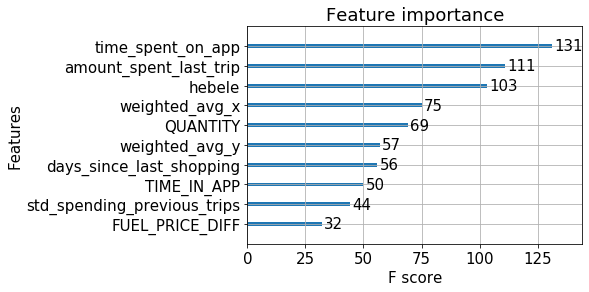

In [107]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)

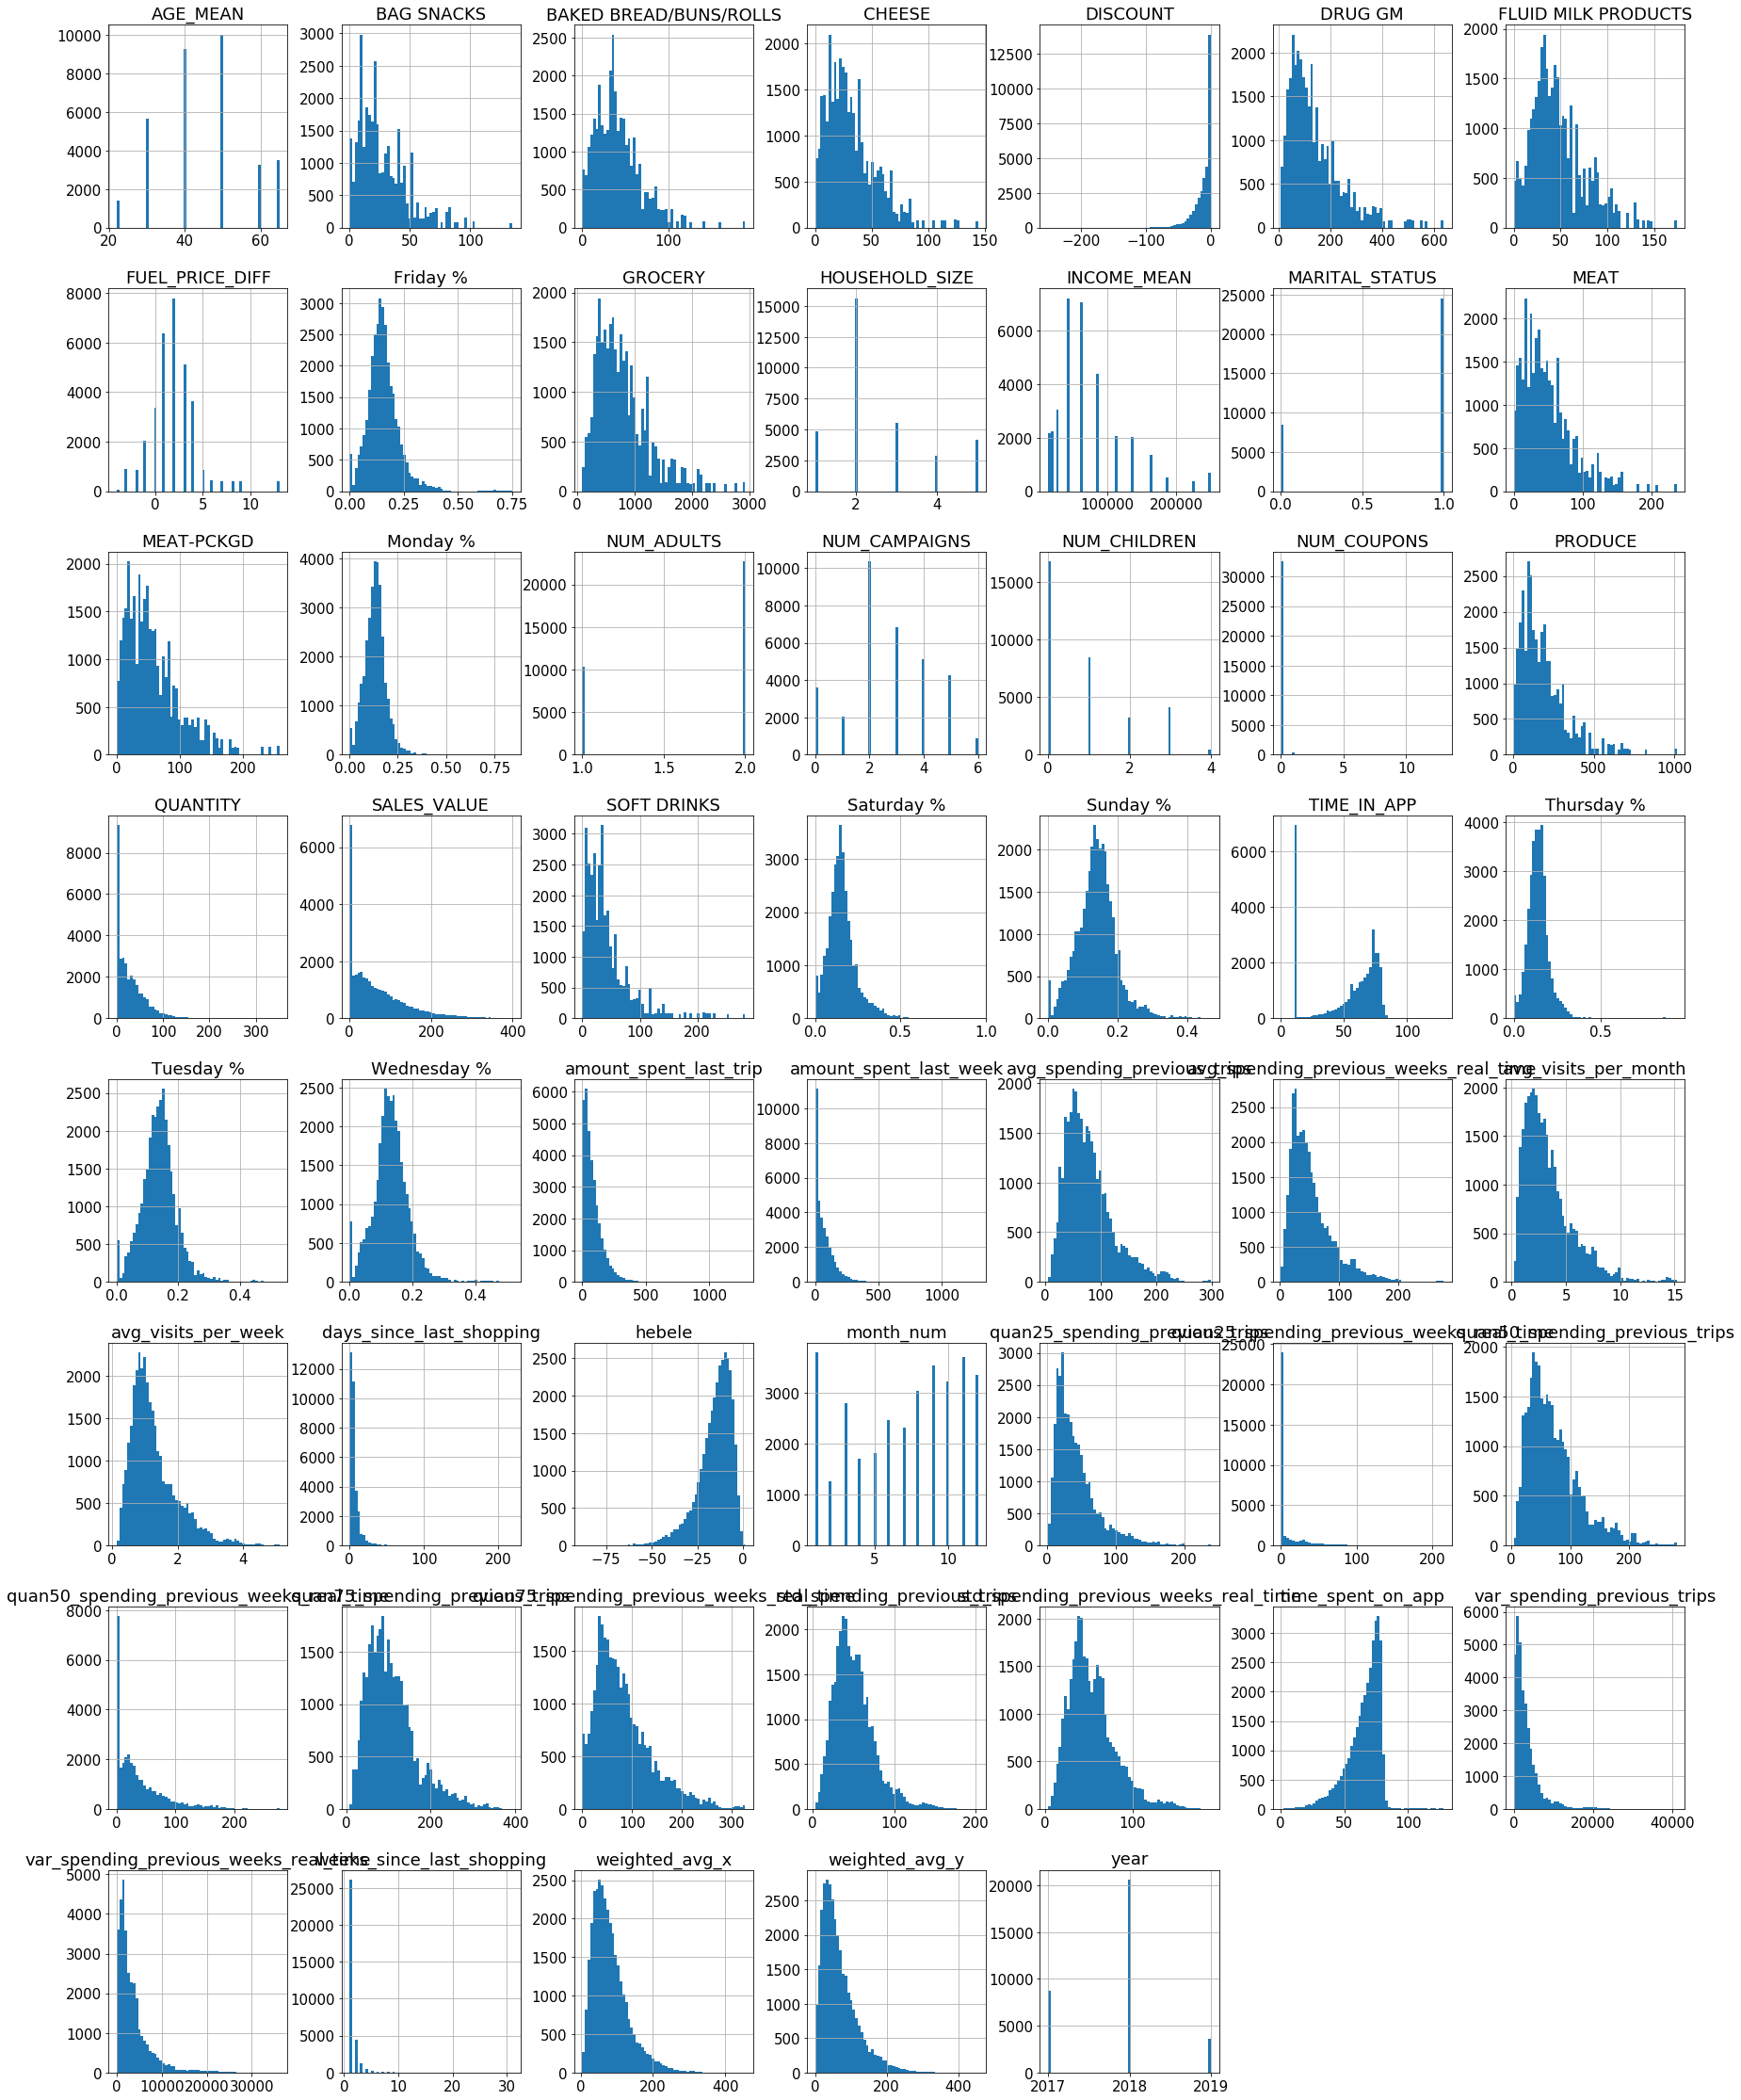

In [108]:
_ = training_data.hist(bins=61, figsize=(30,40))

# Overfit <a class="anchor" id="overfit"></a>

In [113]:
tr = training_data.sample(5000)

In [117]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = tr[columns_to_predict_on]
X = pd.get_dummies(X)
X = np.array(X)
polynomial_features = PolynomialFeatures(degree=3)
X = polynomial_features.fit_transform(X)
print(X.shape)

y = np.array(tr['SALES_VALUE'].tolist())

# transforming the data to include another axis

# X = X[:, np.newaxis]
y = y[:, np.newaxis]

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred_train = model.predict(X_train)



(5000, 59640)


In [118]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_train, y_pred_train)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_train, y_pred_train)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_train, y_pred_train) 
print('R2: ' + str(r2))

mean absolute error: 0.0015232384170770143
mean squared error: 5.772056905576999e-06
root mean squared error: 0.0024025105422405537
R2: 0.9999999988455333


In [119]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, y_pred) 
print('R2: ' + str(r2))

mean absolute error: 35.30899989927451
mean squared error: 191379.63043550763
root mean squared error: 437.4695765827695
R2: -35.660202397975965


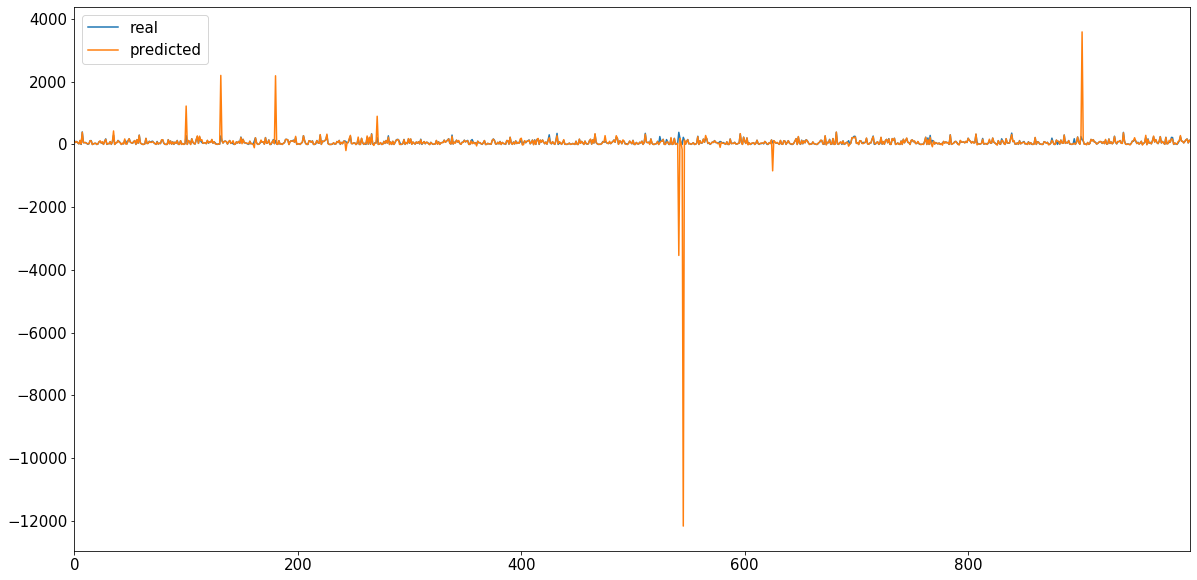

In [120]:
flat_y_test = flat_list = [item for sublist in y_test for item in sublist]
flat_preds = flat_list = [item for sublist in y_pred for item in sublist]

results = pd.DataFrame({'real':flat_y_test, 'predicted':flat_preds})#.sort_values(by='real')
results = results.reset_index().drop('index', axis=1).head(3000)
results.plot(figsize=(20,10))

# Final model <a class="anchor" id="final_model"></a>

In [124]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
X = np.array(X)
polynomial_features = PolynomialFeatures(degree=2)
X = polynomial_features.fit_transform(X)
print(X.shape)

y = np.array(training_data['SALES_VALUE'].tolist())

# transforming the data to include another axis

# X = X[:, np.newaxis]
y = y[:, np.newaxis]

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred_train = model.predict(X_train)



(33063, 2485)


In [125]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_train, y_pred_train)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_train, y_pred_train)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_train, y_pred_train) 
print('R2: ' + str(r2))

mean absolute error: 16.32082411120929
mean squared error: 539.1014622873272
root mean squared error: 23.218558574711892
R2: 0.8924649645916165


In [126]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, y_pred) 
print('R2: ' + str(r2))

mean absolute error: 25.46216679241988
mean squared error: 1760.5005440061618
root mean squared error: 41.95831912751227
R2: 0.6644279916488569
